In [30]:
# Imports

import os
import math
import random
import operator as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math, itertools
import statistics
import json
import hdbscan
from xgboost import XGBClassifier

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn import tree, metrics
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics.pairwise import euclidean_distances
from operator import itemgetter
from statistics import mean
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from collections import Counter
from matplotlib.ticker import StrMethodFormatter

from scipy.spatial import ConvexHull

def load_file(data_file_path):
    data_df = pd.read_csv(data_file_path, delimiter=";")
    return data_df

In [31]:
# Pull and filter all calls <= 20.
max_calls = 20
current_dir = os.getcwd()
mkt_df = load_file(current_dir + '/bank-full.csv')
mkt_df_filtered = mkt_df[(mkt_df['campaign']>=1) & (mkt_df['campaign']<=max_calls)]
mkt_df_filtered = mkt_df_filtered[['job', 'marital', 'education', 'default', 'housing', 'loan', 'age', 'balance', 'campaign', 'y']]
print(mkt_df_filtered.shape)

(44967, 10)


In [32]:
# We use the LabelEncoder from SkLearn to transform the following features.
features_to_transform = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'y']
for feature in features_to_transform:
    le = LabelEncoder()
    le.fit(mkt_df_filtered[feature])
    mkt_df_filtered[feature] = le.transform(mkt_df_filtered[feature])

# Double checking .
kf = KFold(n_splits=5, shuffle=True, random_state = 23)
fold_data = []

for train_index, test_index in kf.split(mkt_df_filtered):
    fold_data.append((train_index, test_index))

   job  marital  education  default  housing  loan  age  balance  campaign  y
0    4        1          2        0        1     0   58     2143         1  0
1    9        2          1        0        1     0   44       29         1  0
2    2        1          1        0        1     1   33        2         1  0
3    1        1          3        0        1     0   47     1506         1  0
4   11        2          3        0        0     0   33        1         1  0
5    4        1          2        0        1     0   35      231         1  0
6    4        2          2        0        1     1   28      447         1  0
7    2        0          2        1        1     0   42        2         1  0
8    5        1          0        0        1     0   58      121         1  0
9    9        2          1        0        1     0   43      593         1  0


In [48]:
# Decisoon Tree

for tt_split in fold_data:
    
    train_index = tt_split[0]
    test_index = tt_split[1]
    
    # Pull data for train test split.
    train_df = mkt_df_filtered.iloc[train_index]
    test_df = mkt_df_filtered.iloc[test_index]
    
    # Split train and test dataframes into input and output.
    train_y = train_df['campaign']
    train_x = train_df.drop(columns=['campaign'])
    test_y = test_df['campaign']
    test_x = test_df.drop(columns=['campaign'])
    
    results_fold = []
    
    # Instantiate the Decision Tree Classifier.
    model = tree.DecisionTreeClassifier()
    model.fit(train_x, train_y)

    # Obtain predictions for the test set.
    predictions = model.predict(test_x)

    # Calls persons based on predications. Note the number of success and calls.
    total_s = 0
    total_c = 0
    t_s = [0]
    t_c = [0]
    
    j = 0
    for index, row in test_x.iterrows():
        if int(predictions[j]) <= test_y.loc[index]:
            if row['y'] == 1:
                total_s += 1
        total_c += int(predictions[j])
        t_s.append(total_s)
        t_c.append(total_c)
        j += 1

    custom_score = metrics.auc(t_c, t_s)
    results_fold.append(custom_score)
    print("Custom score is: ",custom_score)

    acc_score = accuracy_score(test_y, predictions)*100
    print("Accuracy is: ",acc_score)
    print("\n")

Custom score is:  3908126.5
Accuracy is:  26.439848788080944


Custom score is:  4356272.0
Accuracy is:  26.150767178118745


Custom score is:  4316079.5
Accuracy is:  27.38796841988213


Custom score is:  4104808.5
Accuracy is:  26.954297787167796


Custom score is:  4214852.0
Accuracy is:  26.665184032024907




In [43]:
class_weight = [
        {0: 1, 1: 1}, 
        {0: 1, 1: 5}, 
        {0: 1, 1: 1}, 
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1}, 
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
        {0: 1, 1: 1},
    ]
len(class_weight)

32

In [37]:
model.tree_.max_depth

53

In [49]:
# XGBoost

for tt_split in fold_data:
    
    train_index = tt_split[0]
    test_index = tt_split[1]
    
    # Pull data for train test split.
    train_df = mkt_df_filtered.iloc[train_index]
    test_df = mkt_df_filtered.iloc[test_index]
    
    # Split train and test dataframes into input and output.
    train_y = train_df['campaign']
    train_x = train_df.drop(columns=['campaign'])
    test_y = test_df['campaign']
    test_x = test_df.drop(columns=['campaign'])
    
    results_fold = []
    
    # Instantiate the Decision Tree Classifier.
    model = XGBClassifier(max_depth = 10)
    model.fit(train_x, train_y)

    # Obtain predictions for the test set.
    predictions = model.predict(test_x)

    # Calls persons based on predications. Note the number of success and calls.
    total_s = 0
    total_c = 0
    t_s = [0]
    t_c = [0]
    
    j = 0
    for index, row in test_x.iterrows():
        if int(predictions[j]) <= test_y.loc[index]:
            if row['y'] == 1:
                total_s += 1
        total_c += int(predictions[j])
        t_s.append(total_s)
        t_c.append(total_c)
        j += 1

    custom_score = metrics.auc(t_c, t_s)
    results_fold.append(custom_score)
    print("Custom score is: ",custom_score)

    acc_score = accuracy_score(test_y, predictions)*100
    print("Accuracy is: ",acc_score)
    print("\n")

Custom score is:  2994066.5
Accuracy is:  35.95730486991327


Custom score is:  3245594.0
Accuracy is:  36.52434956637759


Custom score is:  3263433.5
Accuracy is:  36.5284109863227


Custom score is:  3016336.5
Accuracy is:  36.194818191927055


Custom score is:  3333942.5
Accuracy is:  36.506171466696316




### Hyper-parameter tuning!

In [5]:
def my_custom_score_func(y_test, y_pred):
    total_s = 0
    total_c = 0
    successes = []
    calls = []
    loc = 0
    for df_ref in y_test.index:
        actual_value = mkt_df_filtered.loc[df_ref]
        if y_pred[loc] <= y_test.iloc[loc]:
            if actual_value['y'] == 1:
                total_s += 1
        total_c += y_pred[loc]
        successes.append(total_s)
        calls.append(total_c)
        loc += 1
    score = metrics.auc(calls, successes)
    return score

custom_score = make_scorer(my_custom_score_func, greater_is_better=True)

model = tree.DecisionTreeClassifier()

dt_opt = GridSearchCV(model,
                   scoring=custom_score,
                   cv=5,
                   param_grid={
                               "criterion": ['gini', 'entropy'],
                               "max_depth": [i for i in range(1, 31)],
                               "min_impurity_decrease": [0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01]
                              }
    )

dt_opt.fit(X, y)

print("Best Parameters: ")
print(dt_opt.best_params_)
print(dt_opt.best_score_)

Best Parameters: 
{'criterion': 'entropy', 'max_depth': 28, 'min_impurity_decrease': 5e-05}
6582897.9


Best Parameters were: 
{'criterion': 'entropy', 'max_depth': 24, 'min_impurity_decrease': 5e-05}
with area being -> 6567663.6

N.B. This was when we utilized the full range of calls for the output variable .... 1-32.

In [20]:
# For obtaining the best hyper-parameters.
print(mkt_df_filtered.head(10))
y = mkt_df_filtered['y']
X = np.array(mkt_df_filtered['age']).reshape(-1, 1)

# Score function in this case would be essentially the result of the Greedy Approach.
def my_custom_score_func(y_test, y_pred):
    total_s = 0
    total_c = 0
    successes = []
    calls = []
    loc = 0
    for df_ref in y_test.index:
        actual_value = mkt_df_filtered.loc[df_ref]
        if y_pred[loc] <= y_test.iloc[loc]:
            if actual_value['y'] == 1:
                total_s += 1
        total_c += y_pred[loc]
        successes.append(total_s)
        calls.append(total_c)
        loc += 1
    score = metrics.auc(calls, successes)
    return score

custom_score = make_scorer(my_custom_score_func, greater_is_better=True)

model = tree.DecisionTreeClassifier()

dt_opt = GridSearchCV(model,
                   scoring=custom_score,
                   cv=5,
                   param_grid={
                               "criterion": ['gini', 'entropy'],
                               "max_depth": [i for i in range(1,10)],
                               "min_impurity_decrease": [0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01]
                              }
    )

dt_opt.fit(X, y)

print("Best Parameters: ")
print(dt_opt.best_params_)
print(dt_opt.best_score_)

   job  marital  education  default  housing  loan  age  balance  campaign  y
0    4        1          2        0        1     0   58     2143         1  0
1    9        2          1        0        1     0   44       29         1  0
2    2        1          1        0        1     1   33        2         1  0
3    1        1          3        0        1     0   47     1506         1  0
4   11        2          3        0        0     0   33        1         1  0
5    4        1          2        0        1     0   35      231         1  0
6    4        2          2        0        1     1   28      447         1  0
7    2        0          2        1        1     0   42        2         1  0
8    5        1          0        0        1     0   58      121         1  0
9    9        2          1        0        1     0   43      593         1  0
Best Parameters: 
{'criterion': 'gini', 'max_depth': 1, 'min_impurity_decrease': 5e-05}
35938.2


### Finding the best age groupings! 

In [56]:
print(mkt_df_filtered.head(10))
y = mkt_df_filtered['y']
X = np.array(mkt_df_filtered['age']).reshape(-1, 1)

   job  marital  education  default  housing  loan  age  balance  campaign  y
0    4        1          2        0        1     0   58     2143         1  0
1    9        2          1        0        1     0   44       29         1  0
2    2        1          1        0        1     1   33        2         1  0
3    1        1          3        0        1     0   47     1506         1  0
4   11        2          3        0        0     0   33        1         1  0
5    4        1          2        0        1     0   35      231         1  0
6    4        2          2        0        1     1   28      447         1  0
7    2        0          2        1        1     0   42        2         1  0
8    5        1          0        0        1     0   58      121         1  0
9    9        2          1        0        1     0   43      593         1  0


[Text(3422.109375, 4983.0, 'X[0] <= 60.5\ngini = 0.207\nsamples = 44967\nvalue = [39682, 5285]'),
 Text(2136.09375, 4077.0, 'X[0] <= 29.5\ngini = 0.195\nsamples = 43779\nvalue = [38996, 4783]'),
 Text(1307.8125, 3171.0, 'X[0] <= 25.5\ngini = 0.291\nsamples = 5236\nvalue = [4309, 927]'),
 Text(697.5, 2265.0, 'X[0] <= 22.5\ngini = 0.366\nsamples = 1326\nvalue = [1006, 320]'),
 Text(348.75, 1359.0, 'X[0] <= 18.5\ngini = 0.429\nsamples = 305\nvalue = [210, 95]'),
 Text(174.375, 453.0, 'gini = 0.486\nsamples = 12\nvalue = [5, 7]'),
 Text(523.125, 453.0, 'gini = 0.42\nsamples = 293\nvalue = [205, 88]'),
 Text(1046.25, 1359.0, 'X[0] <= 24.5\ngini = 0.344\nsamples = 1021\nvalue = [796, 225]'),
 Text(871.875, 453.0, 'gini = 0.347\nsamples = 501\nvalue = [389, 112]'),
 Text(1220.625, 453.0, 'gini = 0.34\nsamples = 520\nvalue = [407, 113]'),
 Text(1918.125, 2265.0, 'X[0] <= 28.5\ngini = 0.262\nsamples = 3910\nvalue = [3303, 607]'),
 Text(1743.75, 1359.0, 'X[0] <= 26.5\ngini = 0.268\nsamples = 273

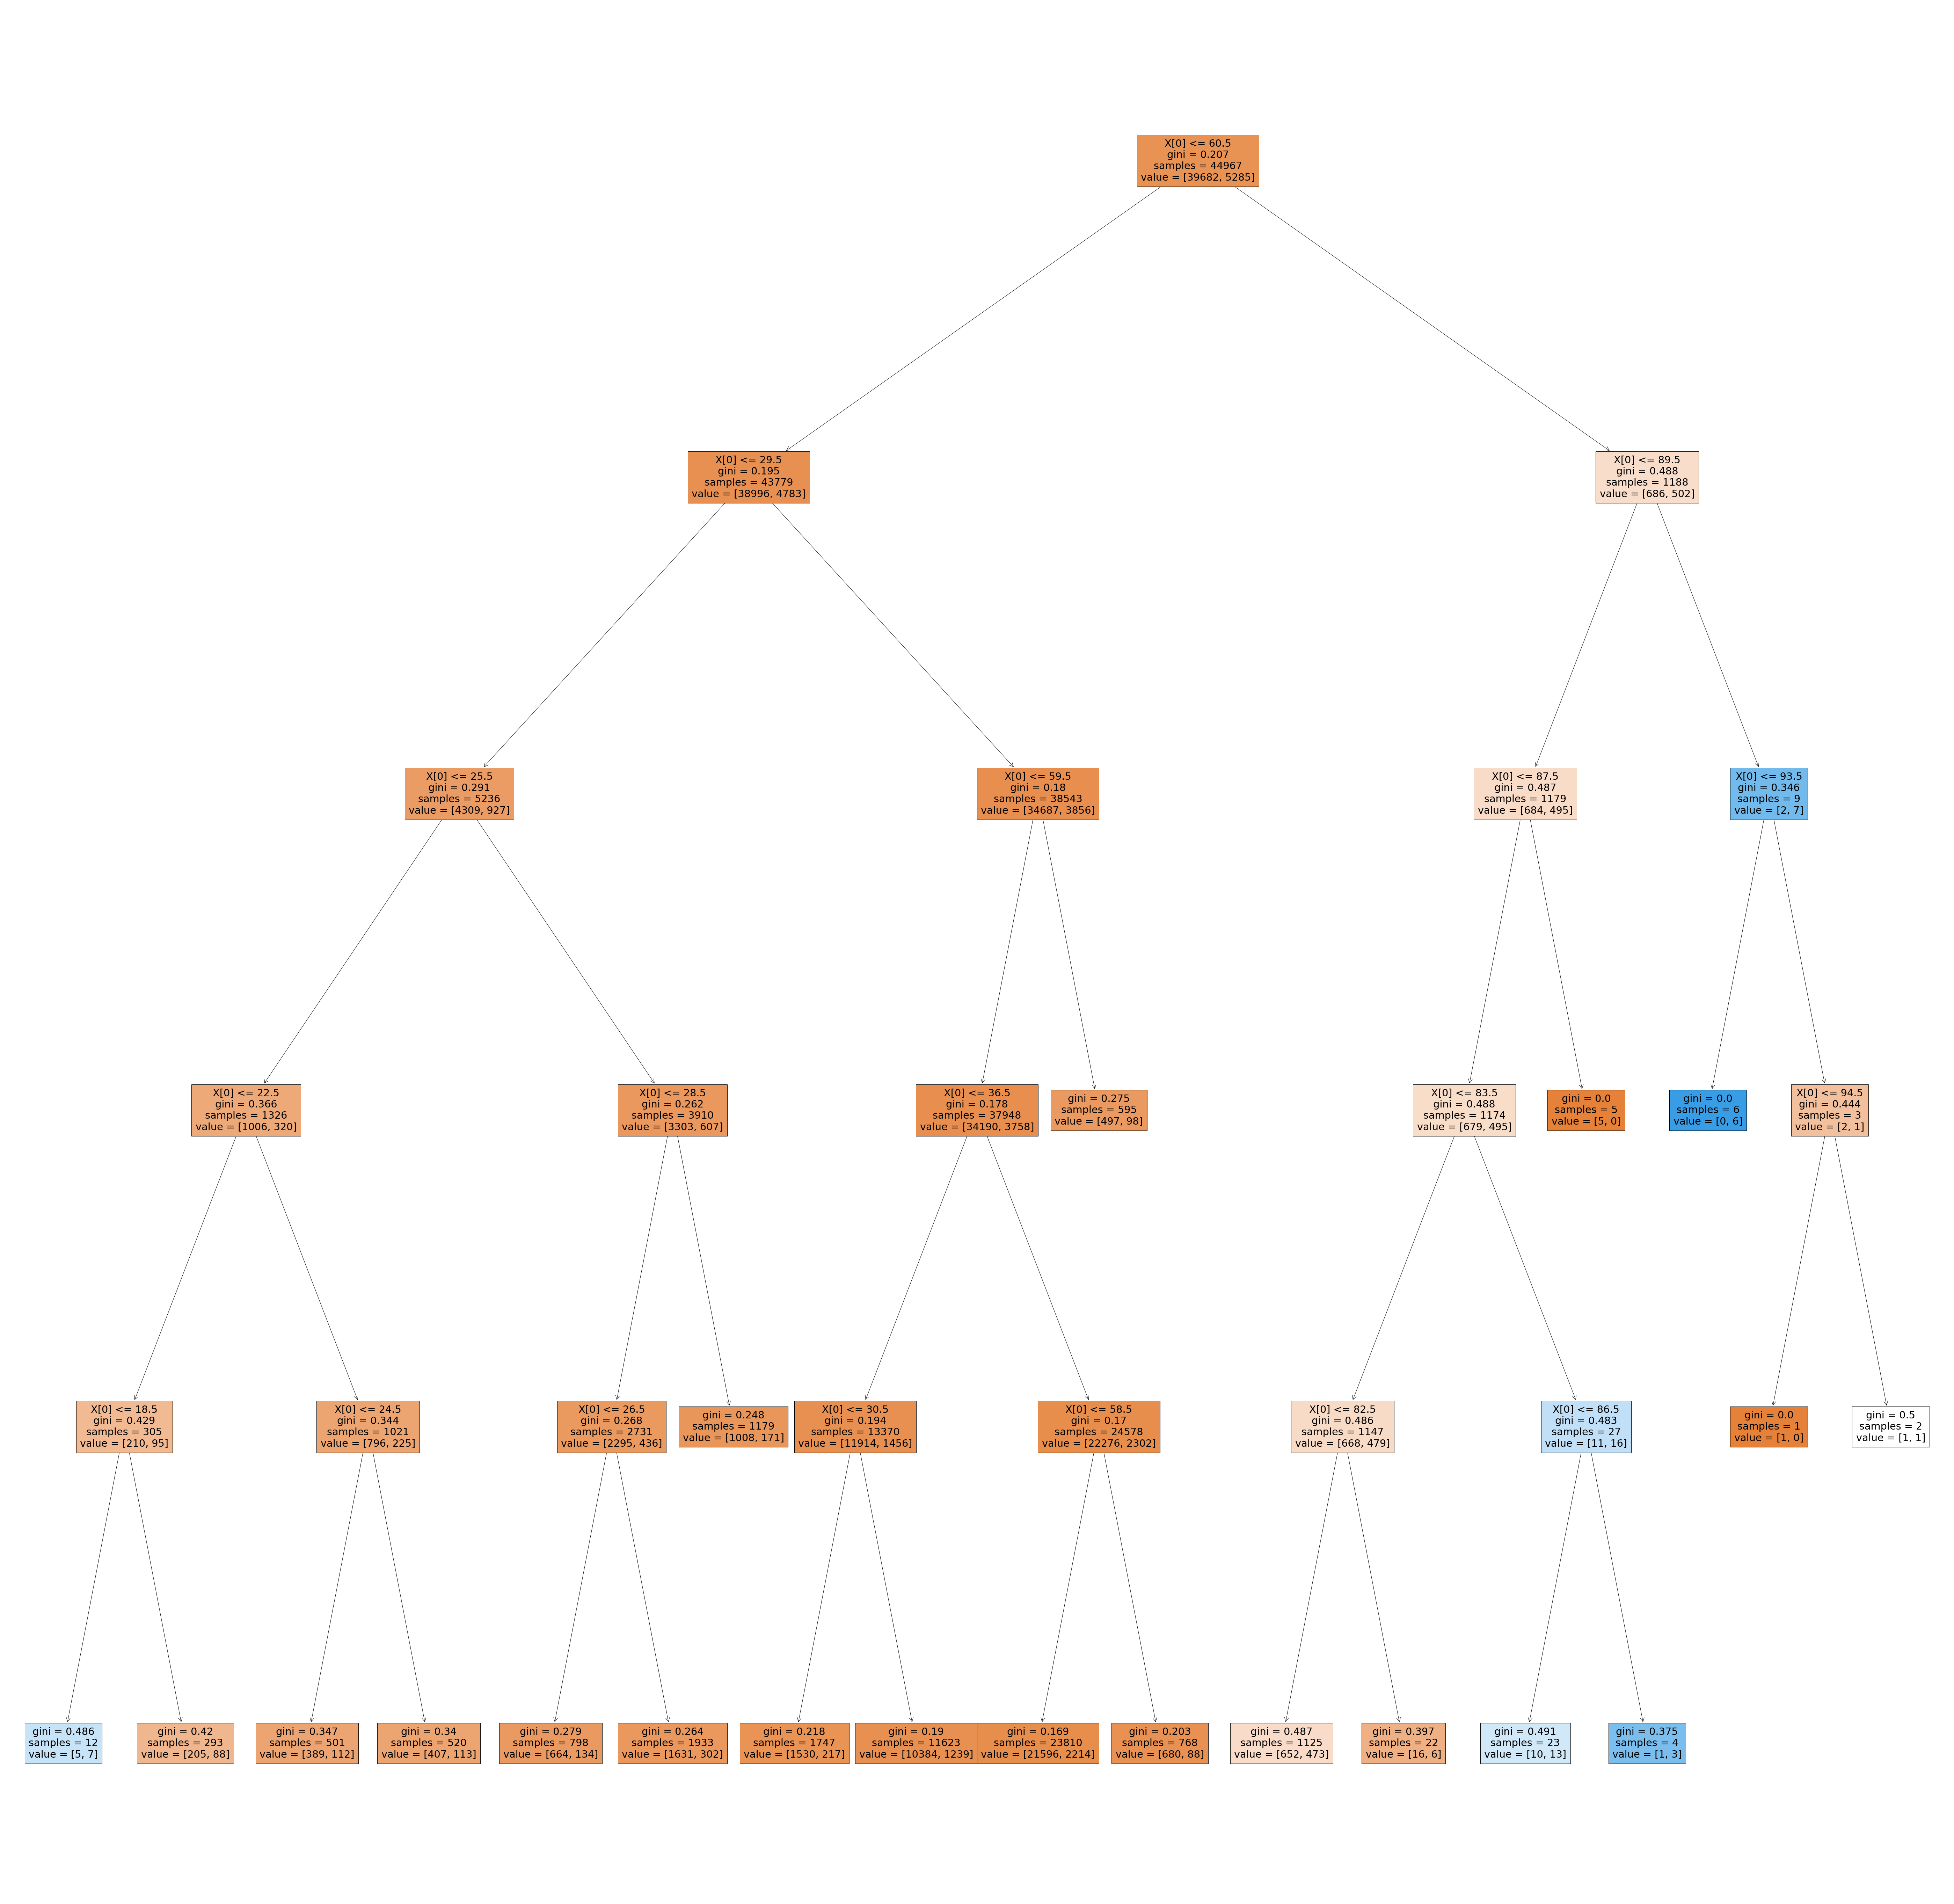

In [57]:
model = tree.DecisionTreeClassifier(max_depth = 5)
model.fit(X, y)

fig, axes = plt.subplots(figsize = (100, 100))
tree.plot_tree(model, filled = True)

In [58]:
# age >= 18 & age <= 30
tup = (18, 30)
age_query_str = "age >= {0} & age <= {1}".format(tup[0], tup[1])
print(age_query_str)

age >= 18 & age <= 30
